In [4]:
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import v2

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = v2.Compose(
    [
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.5,), (0.5,)),
    ]
)

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST(
    "./data", train=True, transform=transform, download=True
)
validation_set = torchvision.datasets.FashionMNIST(
    "./data", train=False, transform=transform, download=True
)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=4, shuffle=False
)

# Class labels
classes = (
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
)

# Report split sizes
print("Training set has {} instances".format(len(training_set)))
print("Validation set has {} instances".format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Coat  Bag  Trouser  Dress


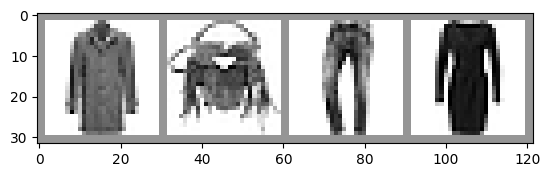

In [5]:
import matplotlib.pyplot as plt
import numpy as np


# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # un-normalize
    np_img = img.numpy()
    if one_channel:
        plt.imshow(np_img, cmap="Greys")
    else:
        plt.imshow(np.transpose(np_img, (1, 2, 0)))


data_iter = iter(training_loader)
images, labels = next(data_iter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print("  ".join(classes[labels[j]] for j in range(4)))

---

## Vision Transformer Model

We will implement:
- Positional Encoding ([Visit here for code provided by PyTorch](https://pytorch.org/tutorials/beginner/translation_transformer.html#seq2seq-network-using-transformer) )
- Patch Embedding
- Vision Transformer Model (using PyTorch Encoder Layer)

---

## Positional Encoding

<img src="./assets/positional-encoding.webp" width="900" height="500"/>

In [3]:
import math

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float = 0.0, maxlen: int = 5000):
        if (emb_size % 2 != 0): raise Exception("Embedding size must be even")
        super(PositionalEncoding, self).__init__()

        # fancy logarithmic stuff to finally calculate 10000^(-2i/emb_size)
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size) 
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        
        
        pos_embedding[:, 0::2] = torch.sin(pos * den) # from 0th index to last index with a step of 2
        pos_embedding[:, 1::2] = torch.cos(pos * den) # from 1st index to last index with a step of 2
        # pos_embedding = pos_embedding.unsqueeze(0) # add a new dimension at the first index, we will use batch_first = True (handle batch dimension)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer("pos_embedding", pos_embedding) # register the tensor as buffer - not updated during backprop

    def forward(self, token_embedding):
        # no learnable parameters
        return self.dropout(token_embedding + self.pos_embedding) 